In [27]:
import cooler
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import json
from io import StringIO
import matplotlib.gridspec as gridspec
import os

In [3]:
json_full =json.load(open("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/down16/full/summary/parameters.json"))

json_roi_expected =json.load(open("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/down16/roi/expected/summary/parameters.json"))

json_roi_lowres =json.load(open("/Users/amulyagarimella/Documents/2241finalproject/outputs/imputed/HiCNN2/down16/roi/lowres/summary/parameters.json"))

In [4]:
dicts_for_df = []
for json, method in [(json_full, "Full HiCNN"), (json_roi_expected, "ROI HiCNN + Expected"), (json_roi_lowres, "ROI HiCNN + Lowres")]:
    for k, v in json.items():
        dict_for_df = {}
        for k2, v2 in v.items():
            for k3, v3 in v2.items():
                dict_for_df["path"] = k
                dict_for_df["Approach"] = method
                dict_for_df[k3] = v3
        dicts_for_df.append(dict_for_df)
        

In [5]:
# Convert nested JSON to Polars DataFrame
data = pl.from_dicts(dicts_for_df)
data.write_csv("/Users/amulyagarimella/Documents/2241finalproject/outputs/experiment_locations.csv")

## Overview

In [6]:
best_roi_model =data.filter(pl.col("ROI_METHOD") == "elasticnet").filter(pl.col("ROI_SPARSITY") == '0.5')

In [7]:
clr_orig = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.mcool::resolutions/10000")

clr_downsampled_16 = cooler.Cooler("/Users/amulyagarimella/Documents/2241finalproject/data/GM12878.GSE115524/processed/GM12878.GSE115524.Homo_Sapiens.CTCF.b1.ds.16.chr21.cool::/")

clr_roi_lowres_hicnn1 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Lowres").filter(pl.col("MODEL") == '1').select("path").unique().item() + "/21_predicted.cool")

clr_roi_lowres_hicnn2 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Lowres").filter(pl.col("MODEL") == '2').select("path").unique().item() + "/21_predicted.cool")

clr_roi_lowres_hicnn3 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Lowres").filter(pl.col("MODEL") == '3').select("path").unique().item() + "/21_predicted.cool")

clr_roi_expected_hicnn1 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '1').select("path").unique().item() + "/21_predicted.cool")

clr_roi_expected_hicnn2 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '2').select("path").unique().item() + "/21_predicted.cool")

clr_roi_expected_hicnn3 = cooler.Cooler(best_roi_model.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '3').select("path").unique().item() + "/21_predicted.cool")

clr_full_hicnn1 = cooler.Cooler(data.filter(pl.col("Approach") == "Full HiCNN").filter(pl.col("MODEL") == '1').select("path").unique().item() + "/21_predicted.cool")

clr_full_hicnn2 = cooler.Cooler(data.filter(pl.col("Approach") == "Full HiCNN").filter(pl.col("MODEL") == '2').select("path").unique().item() + "/21_predicted.cool")

clr_full_hicnn3 = cooler.Cooler(data.filter(pl.col("Approach") == "Full HiCNN").filter(pl.col("MODEL") == '3').select("path").unique().item() + "/21_predicted.cool")

In [8]:
clr_dict = {
    "Original": clr_orig,
    "Downsampled": clr_downsampled_16,
    "ROI HiCNN 1 + Lowres": clr_roi_lowres_hicnn1,
    "ROI HiCNN 2 + Lowres": clr_roi_lowres_hicnn2,
    "ROI HiCNN 3 + Lowres": clr_roi_lowres_hicnn3,
    "ROI HiCNN 1 + Expected": clr_roi_expected_hicnn1,
    "ROI HiCNN 2 + Expected": clr_roi_expected_hicnn2,
    "ROI HiCNN 3 + Expected": clr_roi_expected_hicnn3,
    "Full HiCNN 1": clr_full_hicnn1,
    "Full HiCNN 2": clr_full_hicnn2,
    "Full HiCNN 3": clr_full_hicnn3
}

In [9]:
chrom = "chr21"
start_px = 3000
size_px = 100
resol_bp = 10000

In [10]:
f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"

'chr21:30000000-31000000'

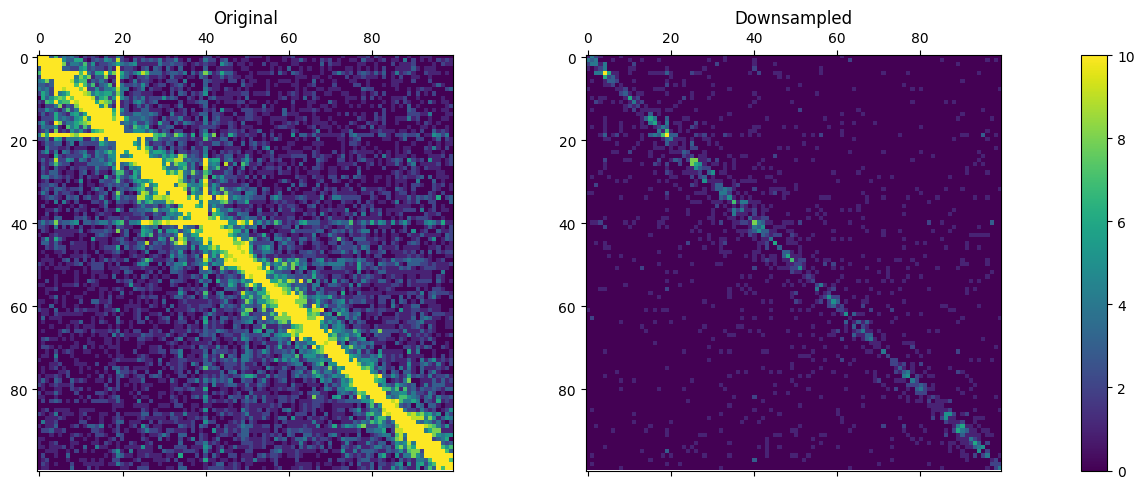

In [11]:
import matplotlib.gridspec as gridspec

# Create figure with GridSpec to allocate space for colorbar
fig = plt.figure(figsize=(12, 5))  # Slightly wider figure
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])  # 3 columns (2 plots + colorbar)

# Create subplots
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Plot matrices
img0 = ax0.matshow(clr_orig.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), vmax=10)
ax0.set_title("Original")

img1 = ax1.matshow(clr_downsampled_16.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), vmax=10)
ax1.set_title("Downsampled")

# Add colorbar in its own subplot
cbar_ax = plt.subplot(gs[2])
fig.colorbar(img1, cax=cbar_ax)

plt.tight_layout()
plt.show()

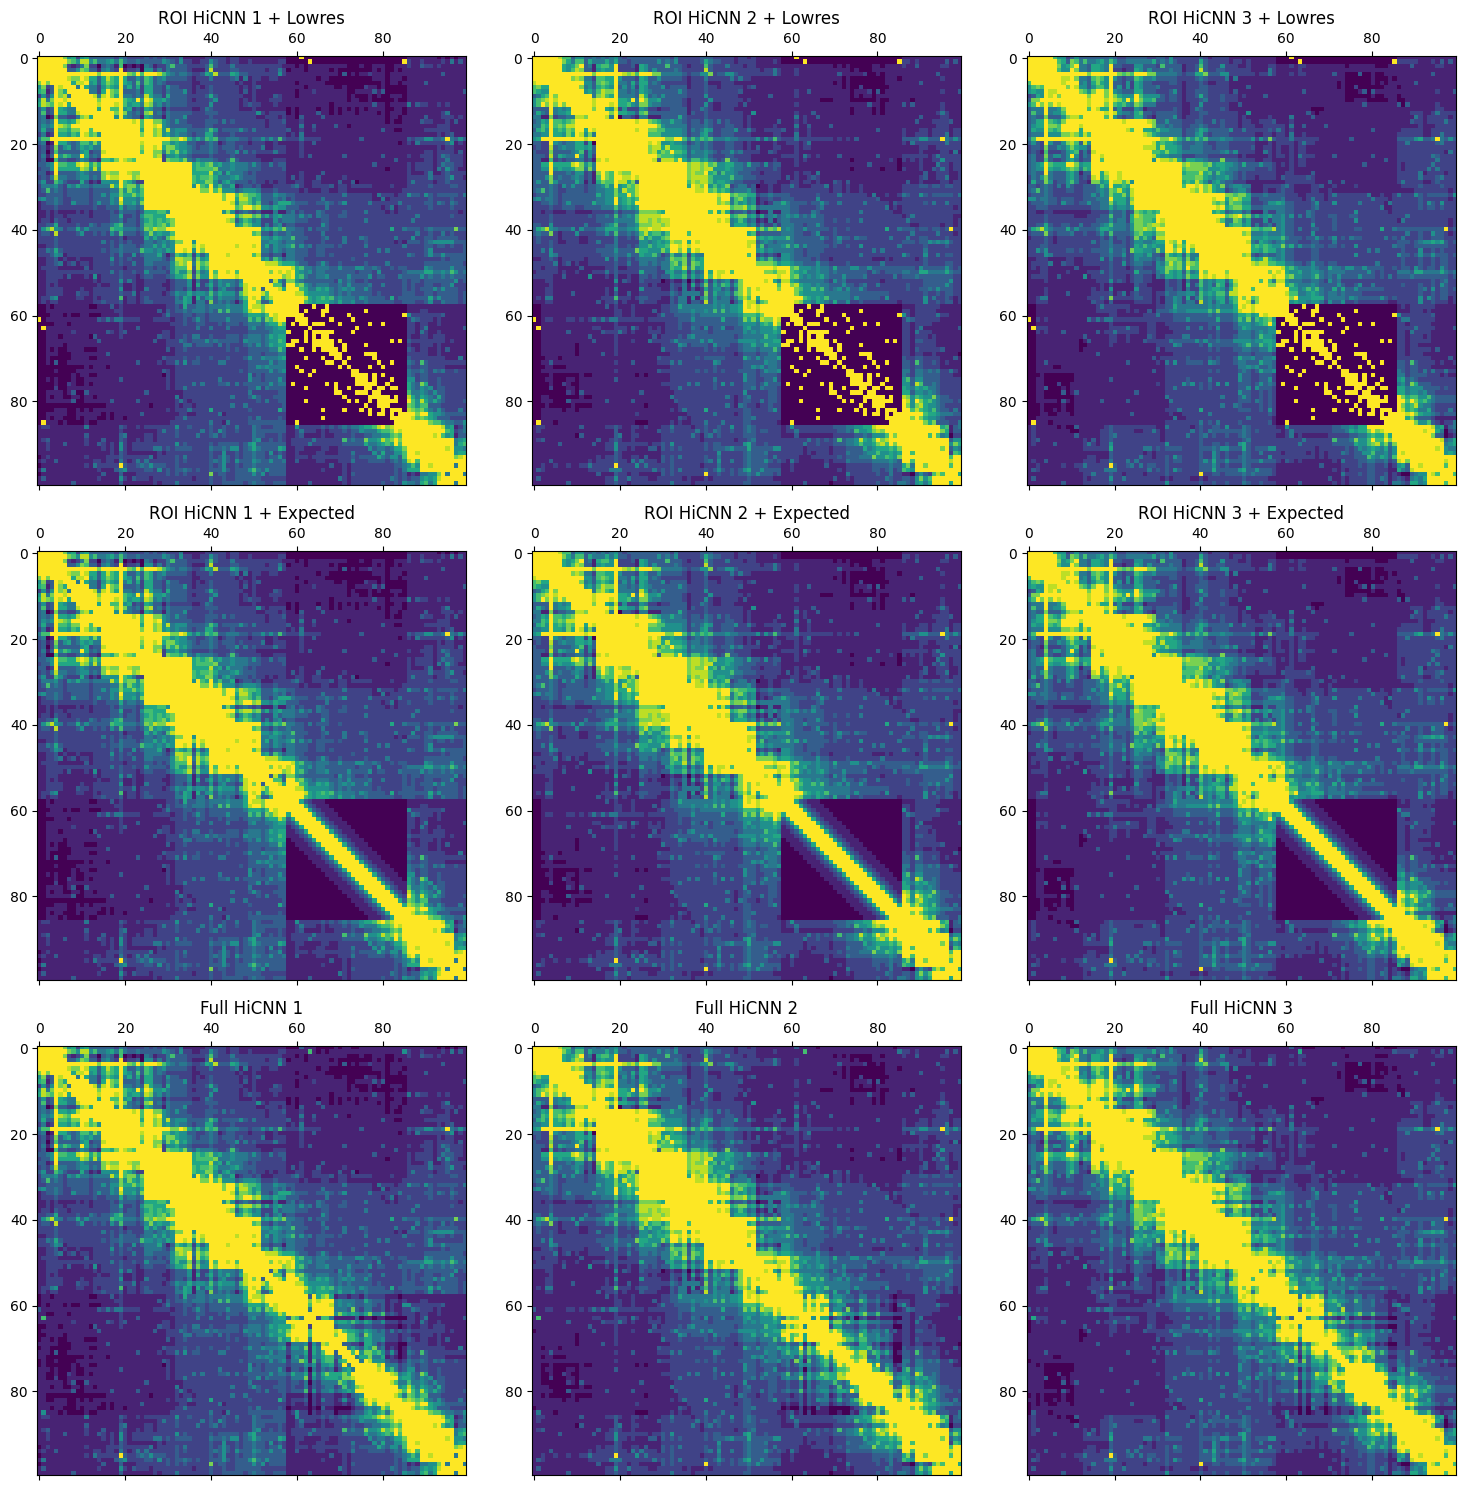

In [12]:
# Determine grid layout based on number of items
n = len(list(clr_dict.items())[2:])
n_cols = min(3, n)  # Max 3 columns
n_rows = (n + n_cols - 1) // n_cols  # Calculate needed rows

# Create figure with appropriate size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

# Flatten axes if needed
axes_flat = axes.flatten()

# Plot each matrix in its own subplot
for i, (title, clr) in enumerate(list(clr_dict.items())[2:]):
    
    ax = axes_flat[i]
    img = ax.matshow(clr.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), 
                    vmax=10)
    
    ax.set_title(title)

plt.tight_layout()
plt.show()

## Sparsities

In [20]:
clr_roi_expected_hicnn1_s10 = cooler.Cooler(data.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '1').filter(pl.col("ROI_METHOD") == "elasticnet").filter(pl.col("ROI_SPARSITY") == '0.1').select("path").unique().item() + "/21_predicted.cool")

clr_roi_expected_hicnn1_s25 = cooler.Cooler(data.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '1').filter(pl.col("ROI_METHOD") == "elasticnet").filter(pl.col("ROI_SPARSITY") == '0.25').select("path").unique().item() + "/21_predicted.cool")

clr_roi_expected_hicnn1_s50 = cooler.Cooler(data.filter(pl.col("Approach") == "ROI HiCNN + Expected").filter(pl.col("MODEL") == '1').filter(pl.col("ROI_METHOD") == "elasticnet").filter(pl.col("ROI_SPARSITY") == '0.5').select("path").unique().item() + "/21_predicted.cool")


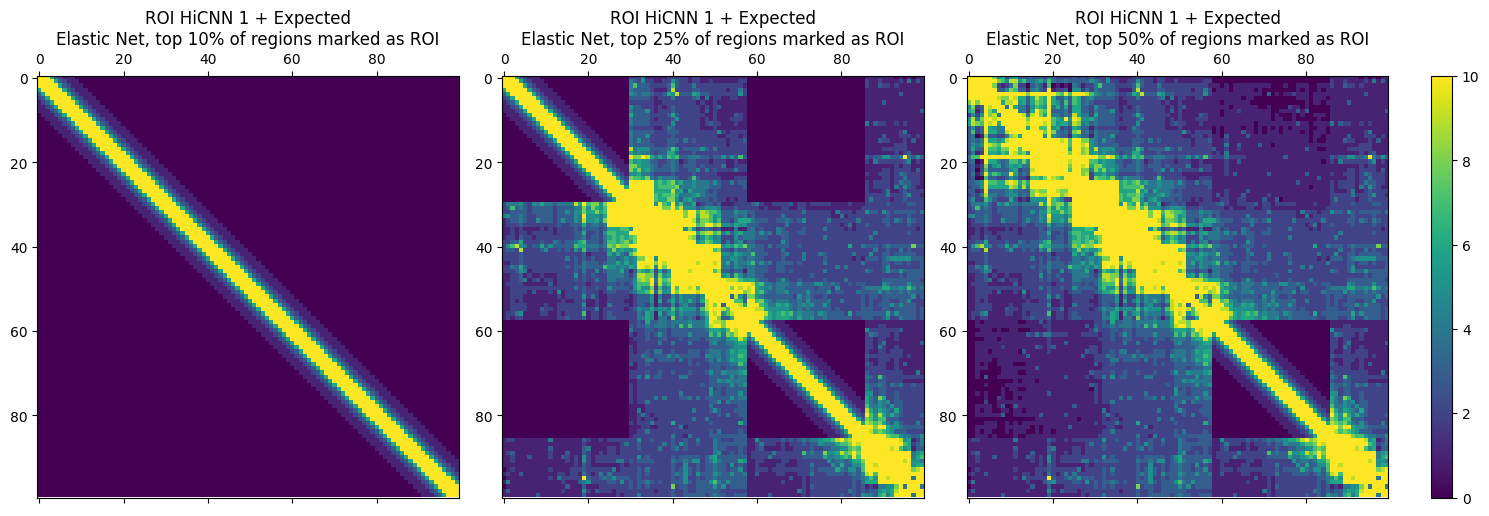

In [28]:
fig = plt.figure(figsize=(15, 5)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1,1, 0.05])  
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

# Plot matrices
img0 = ax0.matshow(clr_roi_expected_hicnn1_s10.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), vmax=10)
ax0.set_title("ROI HiCNN 1 + Expected\nElastic Net, top 10% of regions marked as ROI")

img1 = ax1.matshow(clr_roi_expected_hicnn1_s25.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), vmax=10)
ax1.set_title("ROI HiCNN 1 + Expected\nElastic Net, top 25% of regions marked as ROI")

img2 = ax2.matshow(clr_roi_expected_hicnn1_s50.matrix(balance=False).fetch(f"chr21:{start_px*resol_bp}-{start_px*resol_bp+size_px*resol_bp}"), vmax=10)
ax2.set_title("ROI HiCNN 1 + Expected\nElastic Net, top 50% of regions marked as ROI")

# Add colorbar in its own subplot
cbar_ax = plt.subplot(gs[3])
fig.colorbar(img2, cax=cbar_ax)

plt.tight_layout()
os.makedirs("../figures/fig11", exist_ok=True)
plt.savefig("../figures/fig11/roi_expected_hicnn1_s10_s25_s50_elasticnet.png")
plt.show()